<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.3: Stacking

INSTRUCTIONS:

- Read the guides and hints then create the necessary analysis and code to find an answer and conclusion for the scenario below.
- The baseline results (minimum) are:
    - **Accuracy** = 0.9667
    - **ROC AUC**  = 0.9614
- Try to achieve better results!

# Foreword
It is common that companies and professionals start with the data immediately available. Although this approach works, ideally the first step is to identify the problem or question and only then identify and obtain the set of data that can help to solve or answer the problem.

Also, given the current abundance of data, processing power and some particular machine learning methods, there could be a temptation to use ALL the data available. **Quality** is _**better**_ than **Quantity**!

Part of calling this discipline **Data Science** is that it is supposed to follow a process and not reach conclusions without support from evidence.

Moreover, it is a creative, exploratory, laborious, iterative and interactive process. It is part of the process to repeat, review and change when finding a dead-end.

## Scenario: Predicting Breast Cancer
The dataset you are going to be using for this laboratory is popularly known as the **Wisconsin Breast Cancer** dataset. The task related to it is Classification.

The dataset contains a total number of _10_ features labelled in either **benign** or **malignant** classes. The features have _699_ instances out of which _16_ feature values are missing. The dataset only contains numeric values.

# Step 1: Define the problem or question
Identify the subject matter and the given or obvious questions that would be relevant in the field.

## Potential Questions
List the given or obvious questions.

## Actual Question
Choose the **one** question that should be answered.

# Step 2: Find the Data
### Wisconsin Breast Cancer DataSet
- **Citation Request**

    This breast cancer databases was obtained from the **University of Wisconsin Hospitals**, **Madison** from **Dr. William H. Wolberg**. If you publish results when using this database, then please include this information in your acknowledgements.

- **Title**

    Wisconsin Breast Cancer Database (January 8, 1991)

- **Sources**
    - **Creator**
            Dr. William H. Wolberg (physician)
            University of Wisconsin Hospitals
            Madison, Wisconsin
            USA
    - **Donor**
            Olvi Mangasarian (mangasarian@cs.wisc.edu)
            Received by David W. Aha (aha@cs.jhu.edu)
    - **Date**
            15 July 1992
        
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

# Step 3: Read the Data
- Read the data
- Perform some basic structural cleaning to facilitate the work

In [1]:
import itertools

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from mlxtend.classifier import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
columns = [
    'Sample_Number',
    'Clump_Thickness',
    'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape',
    'Marginal_Adhesion',
    'Single_Epithelial_Cell_Size',
    'Bare_Nuclei',
    'Bland_Chromatin',
    'Normal_Nucleoli',
    'Mitoses',
    'Class'
]
df = pd.read_csv(
    filepath_or_buffer = 'breast-cancer-wisconsin-data-old.csv',
    header = None,
    names = columns,
    usecols = columns[1:], # do not use the first column
    na_values = '?' # convert the '?' to NA
)

In [3]:
df.shape

(699, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump_Thickness              699 non-null    int64  
 1   Uniformity_of_Cell_Size      699 non-null    int64  
 2   Uniformity_of_Cell_Shape     699 non-null    int64  
 3   Marginal_Adhesion            699 non-null    int64  
 4   Single_Epithelial_Cell_Size  699 non-null    int64  
 5   Bare_Nuclei                  683 non-null    float64
 6   Bland_Chromatin              699 non-null    int64  
 7   Normal_Nucleoli              699 non-null    int64  
 8   Mitoses                      699 non-null    int64  
 9   Class                        699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 54.7 KB


In [5]:
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


# Step 4: Explore and Clean the Data
- Perform some initial simple **EDA** (Exploratory Data Analysis)
- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
    - **Null** (values not present or coded [as zero of empty strings])
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)

In [7]:
values = df.values
imputer = SimpleImputer(
    missing_values = np.nan,
    strategy = 'median')
imputedData = imputer.fit_transform(values)

In [8]:
scaler = MinMaxScaler(feature_range = (0, 1))
normalizedData = scaler.fit_transform(imputedData)

In [9]:
df_n = pd.DataFrame.from_records(normalizedData, columns = columns[1:])
df_n['Class'] = df_n['Class'].astype(np.int8)
df_n.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,0
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0,0
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0,0
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0,0
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0,0


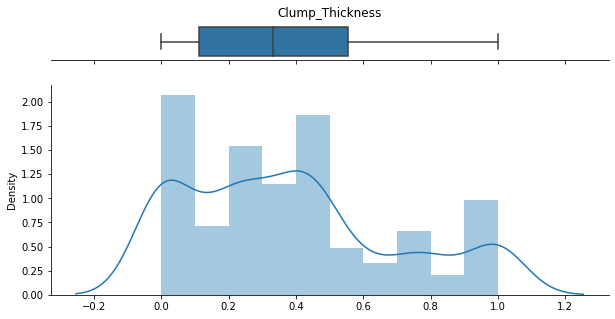

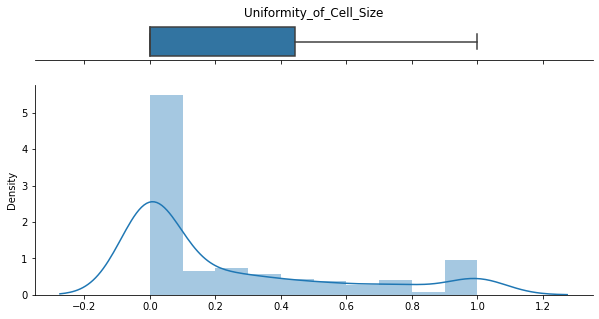

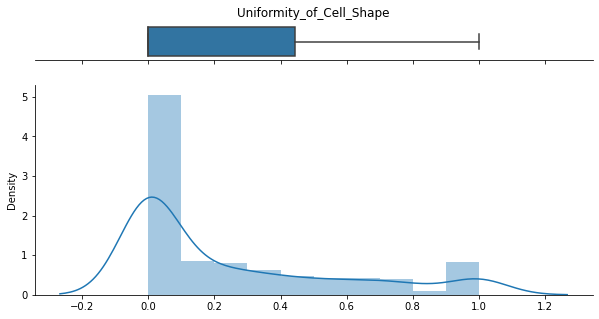

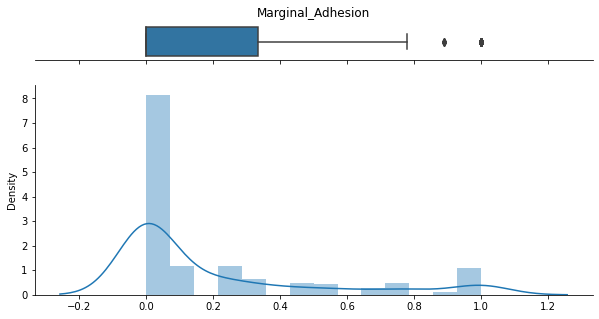

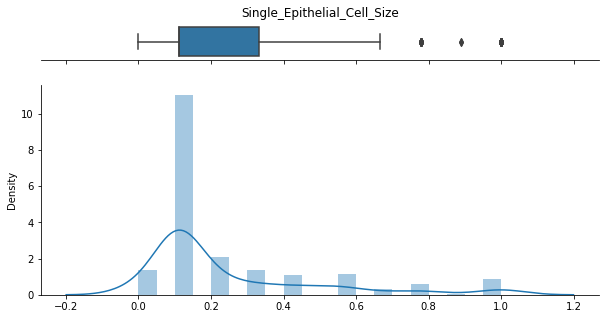

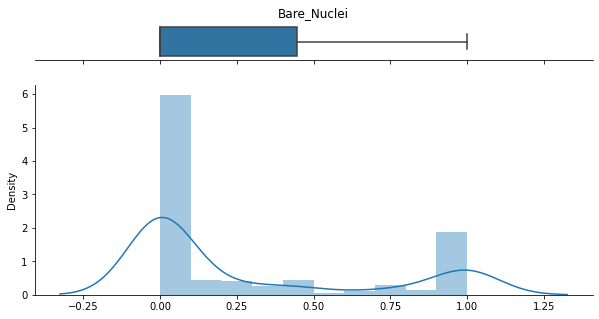

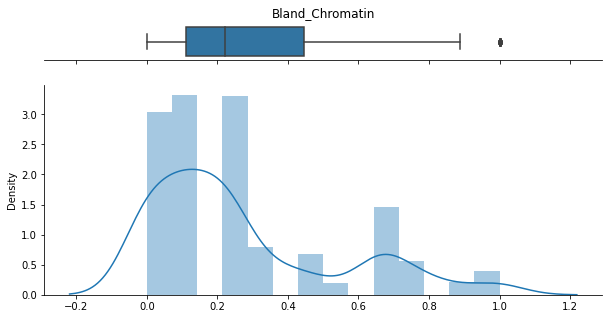

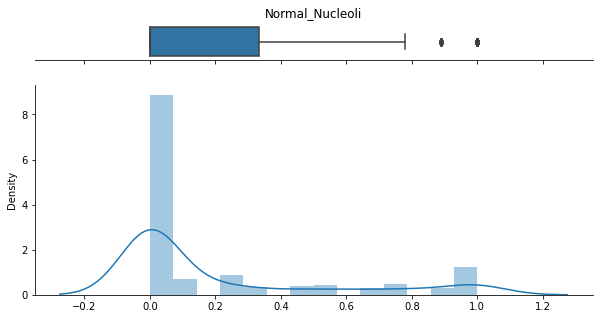

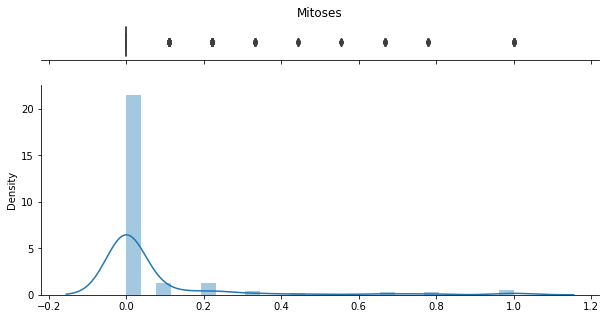

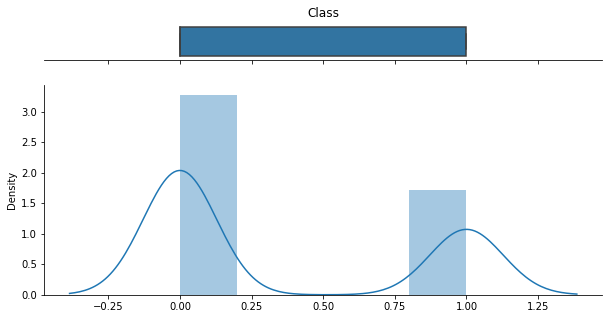

In [10]:
for c in df_n.columns:
    fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

    ax_box = ax[0]
    ax_box = sns.boxplot(df_n[c], ax = ax_box)
    ax_box.set(title = c, yticks = [], xlabel = '')
    sns.despine(ax = ax_box, left = True)

    ax_hist = ax[1]
    ax_hist = sns.distplot(df_n[c], ax = ax_hist)
    ax_hist.set(xlabel = '')
    sns.despine(ax = ax_hist)

plt.show()

In [11]:
features = columns[1:-1] # discard the first and last columns
outcome = 'Class'

# X include all the features
X = df_n[features].copy()
# y is the target variable
y = df_n[outcome].copy()

In [14]:
y.shape

(699,)

In [13]:
X.shape

(699, 9)

# Step 5: Prepare the Data
- Deal with the data as required by the modelling technique
    - **Outliers** (remove or adjust if possible or necessary)
    - **Null** (remove or interpolate if possible or necessary)
    - **Missing Values** (remove or interpolate if possible or necessary)
    - **Coded content** (transform if possible or necessary [str to number or vice-versa])
    - **Normalisation** (if possible or necessary)
    - **Feature Engeneer** (if useful or necessary)

# Step 6: Modelling
Refer to the Problem and Main Question.
- What are the input variables (features)?
- Is there an output variable (label)?
- If there is an output variable:
    - What is it?
    - What is its type?
- What type of Modelling is it?
    - [ ] Supervised
    - [ ] Unsupervised 
- What type of Modelling is it?
    - [ ] Regression
    - [ ] Classification (binary) 
    - [ ] Classification (multi-class)
    - [ ] Clustering

# Step 7: Split the Data

Need to check for **Supervised** modelling:
- Number of known cases or observations
- Define the split in Training/Test or Training/Validation/Test and their proportions
- Check for unbalanced classes and how to keep or avoid it when spliting

In [15]:
X = df.iloc[:,:-1] #omit the last column
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

# Apply imputer and scalar pipeline to each of X_train and X_test separately
pipeline = Pipeline([('imputer', imputer), ('scaler', MinMaxScaler())])

# Pipeline is fit to X_train, then applied to both X_train and X_test
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test) 

# Step 8: Define and Fit Models

Define the model and its hyper-parameters.

Consider the parameters and hyper-parameters of each model at each (re)run and after checking the efficiency of a model against the training and test datasets.

In [16]:
np.random.seed(0)

# create the sub models
clf1 = KNeighborsClassifier(n_neighbors = 1)
clf1.fit(X_train, y_train)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf2.fit(X_train, y_train)
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(X_train, y_train)

# create the ensemble model
sclf = StackingClassifier(
    classifiers = [clf1, clf2, clf3],
    meta_classifier = lr)
sclf.fit(X_train, y_train)
print()

In [19]:
kfold = model_selection.KFold(n_splits = 10, random_state = 7)
results = model_selection.cross_val_score(sclf, X_train, y_train, cv = kfold)
results.mean()

0.9652636054421768

# Step 9: Verify and Evaluate the Training Model
- Use the **training** data to make predictions
- Check for overfitting
- What metrics are appropriate for the modelling approach used
- For **Supervised** models:
    - Check the **Training Results** with the **Training Predictions** during development
- Analyse, modify the parameters and hyper-parameters and repeat (within reason) until the model does not improve

In [23]:
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

********
* K-NN *
********
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


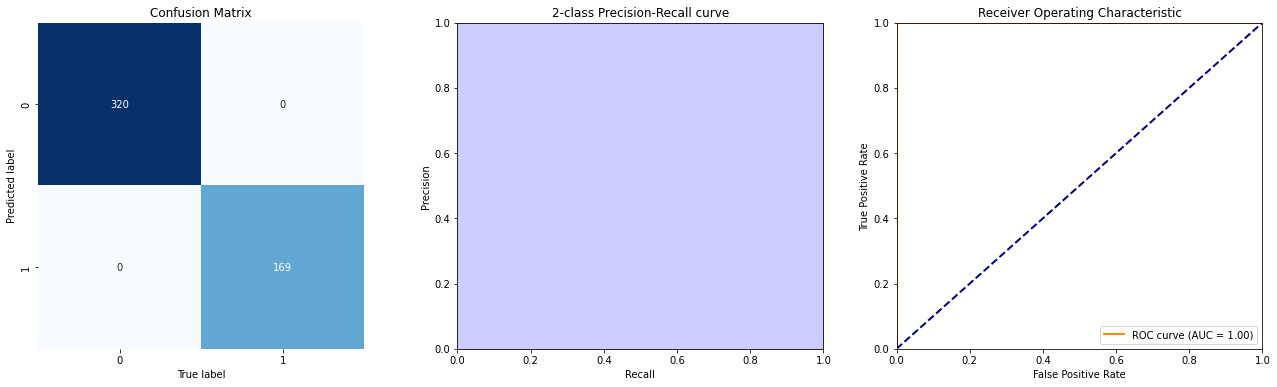


*****************
* Random Forest *
*****************
Accuracy : 0.9980 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9941 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9984                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


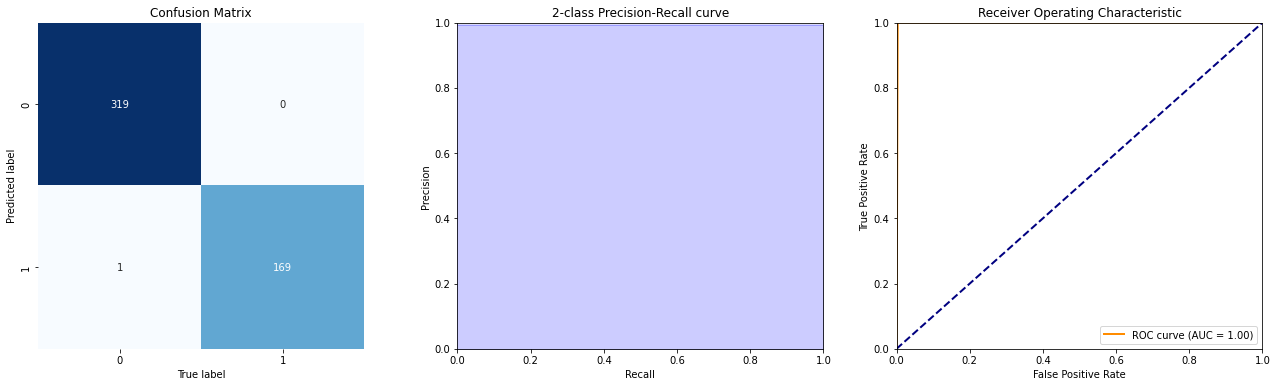


***************
* Naïve Bayes *
***************
Accuracy : 0.9652 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9176 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9882 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9706                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


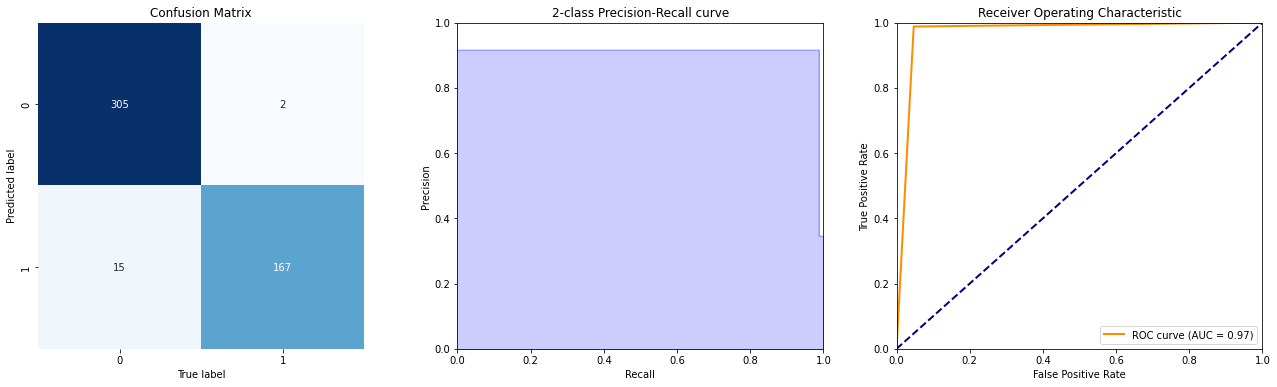


***********************
* Logistic Regression *
***********************
Accuracy : 0.9734 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9699 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9527 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9685                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


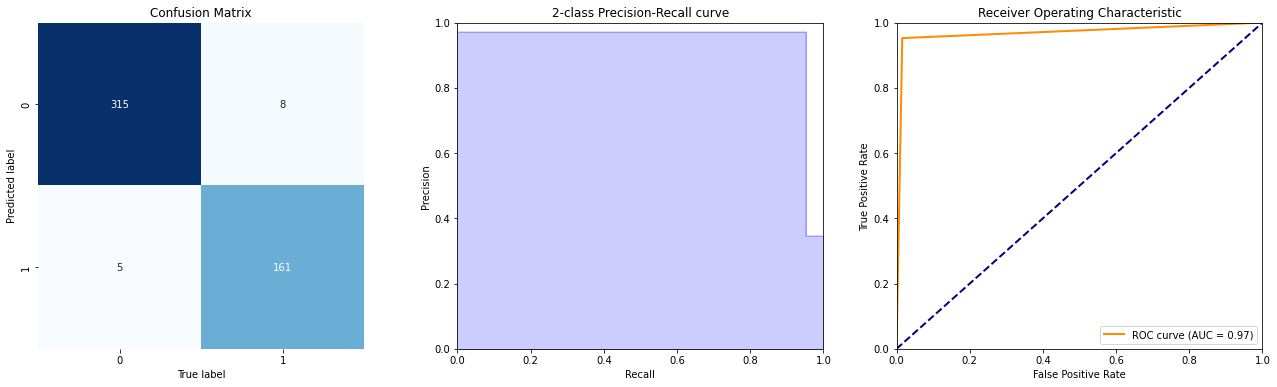


************
* Stacking *
************
Accuracy : 0.9980 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9941 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9984                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


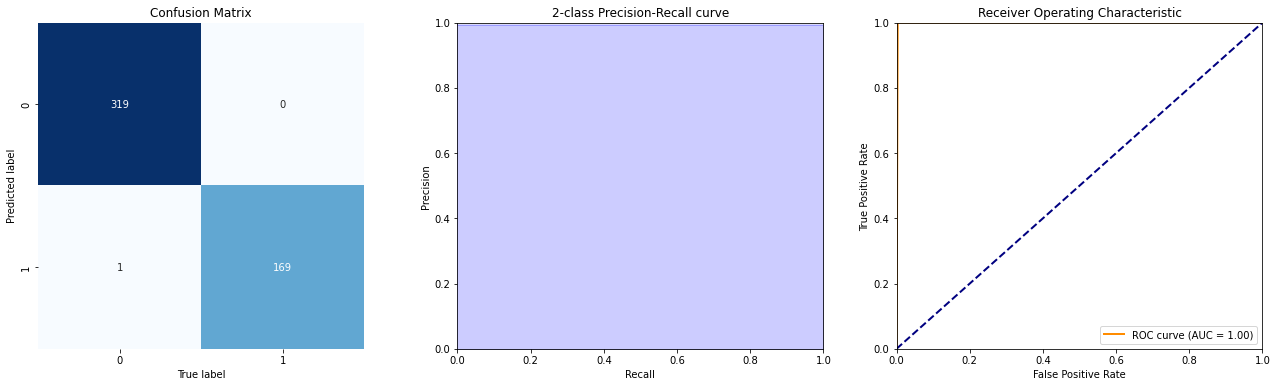

In [21]:
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['K-NN', 'Random Forest', 'Naïve Bayes', 'Logistic Regression', 'Stacking']
for i, m in enumerate([clf1, clf2, clf3, lr, sclf]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(X_train)
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()

In [24]:
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,K-NN,1.000000,1.000000,1.000000,1.000000
1,Random Forest,0.997955,0.994118,1.000000,0.998437
2,Naïve Bayes,0.965235,0.917582,0.988166,0.970645
3,Logistic Regression,0.973415,0.969880,0.952663,0.968519
4,Stacking,0.997955,0.994118,1.000000,0.998437


# Step 10: Make Predictions and Evaluate the Test Model
**NOTE**: **Do this only after not making any more improvements in the model**.

- Use the **test** data to make predictions
- For **Supervised** models:
    - Check the **Test Results** with the **Test Predictions**

In [25]:
predictions = sclf.predict(X_test)

Accuracy : 0.9571 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9200 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9583 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9574                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


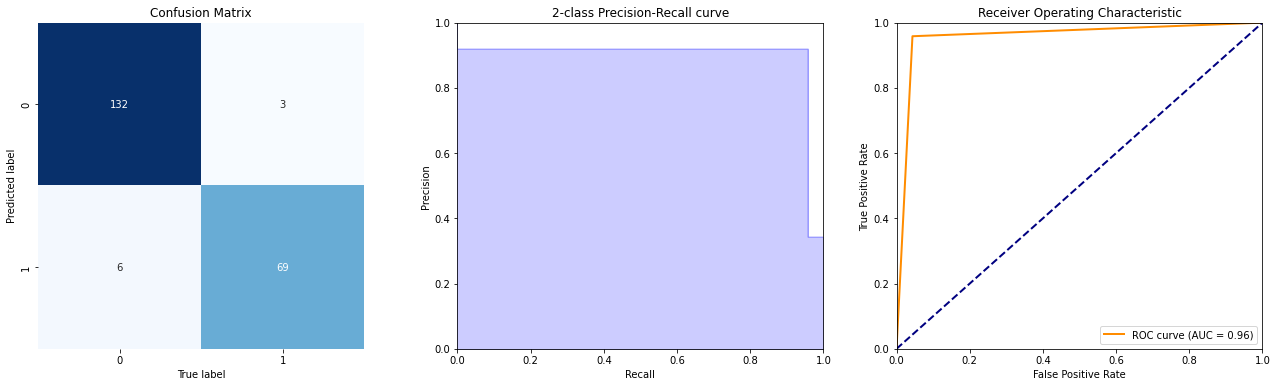

In [26]:
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
# keep the results
results.loc[len(results)] = {
    'Model': 'Stacking (with test)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

In [27]:
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,K-NN,1.000000,1.000000,1.000000,1.000000
1,Random Forest,0.997955,0.994118,1.000000,0.998437
2,Naïve Bayes,0.965235,0.917582,0.988166,0.970645
3,Logistic Regression,0.973415,0.969880,0.952663,0.968519
4,Stacking,0.997955,0.994118,1.000000,0.998437
5,Stacking (with test),0.957143,0.920000,0.958333,0.957428


# Step 11: Solve the Problem or Answer the Question
The results of an analysis or modelling can be used:
- As part of a product or process, so the model can make predictions when new input data is available
- As part of a report including text and charts to help understand the problem
- As input for further questions

In [28]:
r = df.iloc[pd.DataFrame(X_test).index[0]]
for i, c in enumerate(df.columns[:-1]):
    print('%-27s: %d' % (c, int(r[i])))
print('%-27s: %s' % (df.columns[-1], 'Benign' if r[-1] == 2 else 'Malignant'))
print('%-27s: %s' % ('Prediction', 'Benign' if predictions[0] == 0 else 'Malignant'))

Clump_Thickness            : 5
Uniformity_of_Cell_Size    : 1
Uniformity_of_Cell_Shape   : 1
Marginal_Adhesion          : 1
Single_Epithelial_Cell_Size: 2
Bare_Nuclei                : 1
Bland_Chromatin            : 3
Normal_Nucleoli            : 1
Mitoses                    : 1
Class                      : Benign
Prediction                 : Benign




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



